In [1]:
#!pip install jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [1]:
import os
import numpy as np
import pandas as pd
from pprint import pprint

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
path = "train_dataset\\train\\bart\\"

dataset = os.listdir(path)

dataset.sort()

len(dataset)
pprint(dataset)

['pic_0000.jpg',
 'pic_0001.jpg',
 'pic_0002.jpg',
 'pic_0003.jpg',
 'pic_0004.jpg',
 'pic_0005.jpg',
 'pic_0006.jpg',
 'pic_0007.jpg',
 'pic_0008.jpg',
 'pic_0009.jpg',
 'pic_0010.jpg',
 'pic_0011.jpg',
 'pic_0012.jpg',
 'pic_0013.jpg',
 'pic_0014.jpg',
 'pic_0015.jpg',
 'pic_0016.jpg',
 'pic_0017.jpg',
 'pic_0018.jpg',
 'pic_0019.jpg',
 'pic_0020.jpg',
 'pic_0021.jpg',
 'pic_0022.jpg',
 'pic_0023.jpg',
 'pic_0024.jpg',
 'pic_0025.jpg',
 'pic_0026.jpg',
 'pic_0027.jpg',
 'pic_0028.jpg',
 'pic_0029.jpg',
 'pic_0030.jpg',
 'pic_0031.jpg',
 'pic_0032.jpg',
 'pic_0033.jpg',
 'pic_0034.jpg',
 'pic_0035.jpg',
 'pic_0036.jpg',
 'pic_0037.jpg',
 'pic_0038.jpg',
 'pic_0039.jpg',
 'pic_0040.jpg',
 'pic_0041.jpg',
 'pic_0042.jpg',
 'pic_0043.jpg',
 'pic_0044.jpg',
 'pic_0045.jpg',
 'pic_0046.jpg',
 'pic_0047.jpg',
 'pic_0048.jpg',
 'pic_0049.jpg',
 'pic_0050.jpg',
 'pic_0051.jpg',
 'pic_0052.jpg',
 'pic_0053.jpg',
 'pic_0054.jpg',
 'pic_0055.jpg',
 'pic_0056.jpg',
 'pic_0057.jpg',
 'pic_0058.jpg

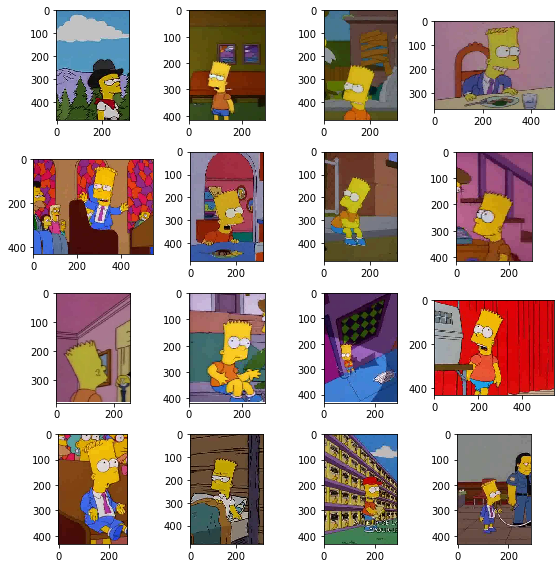

In [4]:
fig = plt.figure(figsize=(8, 8))

for i in range(16):

    plt.subplot(4, 4, 1 + i)
    plt.tight_layout()

    image_bgr = cv2.imread(path + "{}".format(dataset[i]))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb, cmap="rainbow", interpolation="none")
    #target = np.where(example_target[i]==1)[0]
    #plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [5]:
for i in range(5):
  image_bgr = cv2.imread(path + "{}".format(dataset[i]))
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  print(image_rgb.shape)

(480, 320, 3)
(416, 288, 3)
(480, 320, 3)
(368, 496, 3)
(432, 544, 3)


## Dataframe으로 정리

In [2]:
top_path = "train_dataset\\train\\"
path_list = []
category_list = []
categories = ["bart", "charles_montgomery", "krusty", "lisa_simpson", "marge_simpson", "milhouse_van_houten", "moe_szyslak", "ned_flanders", "principal_skinner"]

for category in categories:
  path = top_path+category+"\\"
  dataset = os.listdir(path)
  
  for data in dataset:
    path_list.append(path + "{}".format(data))
    category_list.append(category)


df = pd.DataFrame({"path": path_list, "category": category_list})

print(df.shape)
print(df["category"].unique())
df.value_counts("category")

(11248, 2)
['bart' 'charles_montgomery' 'krusty' 'lisa_simpson' 'marge_simpson'
 'milhouse_van_houten' 'moe_szyslak' 'ned_flanders' 'principal_skinner']


category
ned_flanders           1454
moe_szyslak            1452
lisa_simpson           1354
marge_simpson          1311
bart                   1218
principal_skinner      1193
krusty                 1101
charles_montgomery     1086
milhouse_van_houten    1079
dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11248 entries, 0 to 11247
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      11248 non-null  object
 1   category  11248 non-null  object
dtypes: object(2)
memory usage: 175.9+ KB


In [4]:
df

,path,category
0,train_dataset\train\bart\pic_0000.jpg,bart
1,train_dataset\train\bart\pic_0001.jpg,bart
2,train_dataset\train\bart\pic_0002.jpg,bart
3,train_dataset\train\bart\pic_0003.jpg,bart
4,train_dataset\train\bart\pic_0004.jpg,bart
...,...,...
11243,train_dataset\train\principal_skinner\pic_1190...,principal_skinner
11244,train_dataset\train\principal_skinner\pic_1191...,principal_skinner
11245,train_dataset\train\principal_skinner\pic_1192...,principal_skinner
11246,train_dataset\train\principal_skinner\pic_1193...,principal_skinner


# Data Loader + Preprocessing

In [5]:
#!/usr/bin/env python3
#!pip install einops
#!pip install tensorflow --user

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2, DenseNet121, EfficientNetB0, ResNet101V2

from einops import rearrange
from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.utils import to_categorical, Sequence

class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels, 
    batch_size, img_size, img_channel, num_classes, augmentations, shuffle=False):
     
        # 데이터 이미지 개별 주소 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.list_IDs = list_IDs
        # 데이터 라벨 리스트 [ DataFrame 형식 (image 주소, image 클래스) ]
        self.labels = labels
        # 학습 Batch 사이즈
        self.batch_size = batch_size
        # 이미지 리사이징 사이즈
        self.img_size = img_size
        # 이미지 채널 [RGB or Gray]
        self.img_channel = img_channel
        # 데이터 라벨의 클래스 수
        self.num_classes = num_classes
        # 전체 데이터 수
        self.indexes = np.arange(len(self.list_IDs))
        self.shuffle=shuffle
        self.on_epoch_end()
        self.augment = augmentations
   
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation__(list_IDs_temp, index)
        
        return np.stack([
            self.augment(image=x)["image"] for x in X
        ], axis=0), y#to_categorical(y, num_classes=self.num_classes)
        #return X, y
            
    def __data_generation__(self, list_IDs_temp, index):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel), dtype='uint8')
        y = np.zeros((self.batch_size, self.num_classes), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img
            y[i, ] = to_categorical(self.labels[index*self.batch_size+i], num_classes=self.num_classes)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [7]:
import albumentations as A

AUGMENTATIONS_TRAIN = A.Compose([
    A.CLAHE(p=1.0, clip_limit=2.0),
    A.ToFloat(max_value=255),
    A.HorizontalFlip(p=0.5),
    #A.RandomContrast(limit=0.2, p=0.5),
    #A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    #A.RandomBrightness(limit=0.2, p=0.5),
    #A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       #val_shift_limit=10, p=.9),
    
    #A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8)
])
AUGMENTATIONS_TEST = A.Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    A.ToFloat(max_value=255)
])

In [8]:
# 전체 클래스 수
clss_num = len(df['category'].unique())
# 클래스 -> 숫자로 변환 (카테고리 형식의 클래스를 원 핫 인코딩)
labels_dict = dict(zip(df['category'].unique(), range(clss_num)))
df = df.replace({"category": labels_dict})

data = df['path']
target = df['category']


x_train, x_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target)
x_train.reset_index(drop=True, inplace=True), x_valid.reset_index(drop=True, inplace=True), y_train.reset_index(drop=True, inplace=True), y_valid.reset_index(drop=True, inplace=True)


(None, None, None, None)

In [13]:
x_train, y_train

(0       train_dataset\train\principal_skinner\pic_0458...
 1           train_dataset\train\ned_flanders\pic_0415.jpg
 2           train_dataset\train\lisa_simpson\pic_1056.jpg
 3                   train_dataset\train\bart\pic_0492.jpg
 4       train_dataset\train\charles_montgomery\pic_074...
                               ...                        
 8993              train_dataset\train\krusty\pic_0544.jpg
 8994        train_dataset\train\ned_flanders\pic_1432.jpg
 8995    train_dataset\train\charles_montgomery\pic_086...
 8996    train_dataset\train\milhouse_van_houten\pic_07...
 8997        train_dataset\train\lisa_simpson\pic_0073.jpg
 Name: path, Length: 8998, dtype: object,
 0       8
 1       7
 2       3
 3       0
 4       1
        ..
 8993    2
 8994    7
 8995    1
 8996    5
 8997    3
 Name: category, Length: 8998, dtype: int64)

In [9]:
target_size = 224
img_ch = 3
num_class = 9
batch_size = 32

train_generator = DataGenerator(x_train,
                                y_train,
                                batch_size, target_size, 
                                img_ch, num_class, AUGMENTATIONS_TRAIN)
valid_generator = DataGenerator(x_valid, 
                                y_valid,
                                batch_size, target_size,
                                img_ch, num_class, AUGMENTATIONS_TEST)

In [15]:
x_train.shape

(8998,)

Target: (32, 9)
Data  : (32, 224, 224, 3)
[0 0 0 1 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 1 0 0]


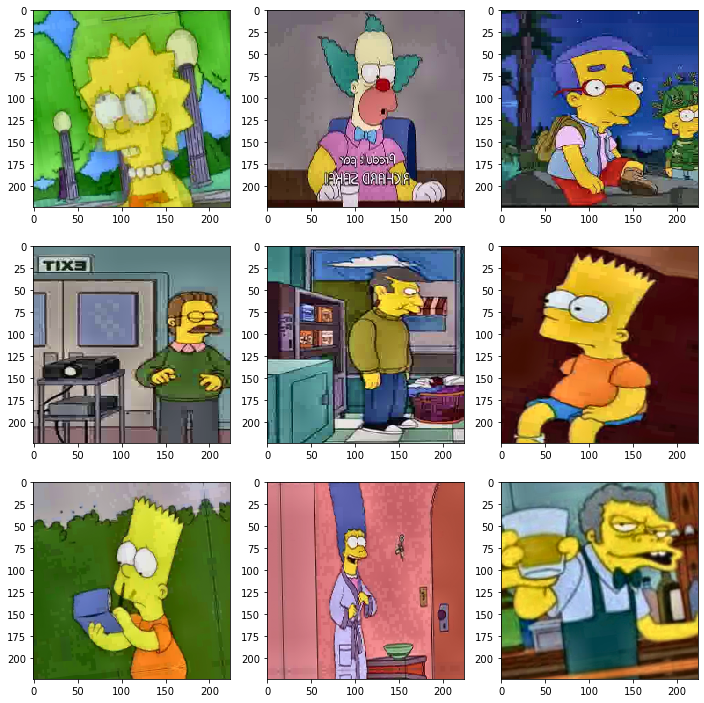

In [13]:
examples = enumerate(train_generator)
next(examples)
next(examples)
next(examples)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    #plt.title("Ground Truth: {}".format(category.get(int(target))))
    print(example_target[i])
plt.show()

## 모델 구현

### 일반 모델

In [15]:
inputs = Input(shape=(224, 224, 3))

X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(inputs)
X = BatchNormalization()(X)
X = Activation("swish")(X)
X = Conv2D(filters=64, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(X)
X = Activation("swish")(X)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)

X = Conv2D(filters=32, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation("swish")(X)
X = Conv2D(filters=32, kernel_size=(3, 3), padding="Same", kernel_initializer='he_uniform')(X)
X = Activation("swish")(X)

X = tf.keras.layers.GlobalAveragePooling2D()(X)

X = Dense(128, activation="swish")(X)
X = BatchNormalization()(X)
X = Dropout(0.4)(X)
X = Dense(64, activation="swish")(X)
X = BatchNormalization()(X)
X = Dropout(0.2)(X)
outputs = Dense(9, activation="softmax")(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0     

### 전이 학습 모델 (Resnet)

In [17]:
inputs = Input(shape=(224,224,3))
base_model = ResNet101V2(input_tensor=inputs,
                         weights="imagenet", 
                         #input_shape=(224, 224, 3), 
                         include_top=False)

#base_model.trainable = False
#base_model.summary()



X = base_model.output    #, training = False)
X = GlobalAveragePooling2D()(X)
X = Dense(128, activation="swish")(X)
#X = BatchNormalization()(X)
X = Dropout(0.5)(X)
outputs = Dense(9, activation="Softmax")(X)

model = Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [22]:
%%notify
def scheduler(epoch, lr):
  if epoch < 8:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

checkpoint_filepath = 'best_model.h5'


callback = [
            tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
            tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                               monitor="val_loss", 
                                               mode="min",
                                               save_best_only=True)
]

#model.compile(optimizer='RMSprop', loss="categorical_crossentropy", metrics=["accuracy"])
#history = model.fit(train_generator, epochs=20, callbacks = callback, validation_data=valid_generator, verbose=1)
#model.load_weights(checkpoint_filepath)

<IPython.core.display.Javascript object>

In [19]:
from tensorflow.keras import models, layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math
 
K = 9
 
 
input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
 
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x
 
 
 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
x = conv5_layer(x)
 
x = GlobalAveragePooling2D()(x)
output_tensor = Dense(K, activation='softmax')(x)
 
resnet50 = Model(input_tensor, output_tensor)
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [20]:
resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [23]:
history = resnet50.fit(train_generator, epochs=30, callbacks = callback, validation_data=valid_generator, verbose=1)

Epoch 1/30
282/282 [==============================] - 80s 234ms/step - loss: 2.3790 - accuracy: 0.1608 - val_loss: 3.9615 - val_accuracy: 0.0321: 0 - ETA: 19s - loss: 2.4533 - accu - ETA: 16s - loss: 2.4414 - accuracy:  - ETA: 15s - loss: 2.4344 - - ETA: 11s - loss: 2.417


C:\Users\paulh\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
282/282 [==============================] - 64s 228ms/step - loss: 2.1744 - accuracy: 0.1729 - val_loss: 2.7454 - val_accuracy: 0.0907
Epoch 3/30
282/282 [==============================] - 64s 228ms/step - loss: 2.1550 - accuracy: 0.1815 - val_loss: 2.3772 - val_accuracy: 0.0951 loss: 2.1550 - accuracy: 0.18
Epoch 4/30
282/282 [==============================] - 65s 230ms/step - loss: 2.1509 - accuracy: 0.1745 - val_loss: 2.6169 - val_accuracy: 0.1840 ETA: 6s - loss: 2.150
Epoch 5/30
282/282 [==============================] - 64s 228ms/step - loss: 2.1552 - accuracy: 0.1739 - val_loss: 2.2183 - val_accuracy: 0.0528A: 52s - loss: 2.1550 - accuracy: 0.17 - ETA: 51s - loss: 2.1541 - accuracy: 0.17 - ETA: 51s - loss: 2 - ETA: 46s - loss: 2.1549 - accuracy: 0 - ETA: 45s - loss: 2.1560 -  - ETA: 14s - los - ETA: 9s - loss: 2 - ETA: 6s - loss: 2.1548 - accuracy: 0.17 - ETA: 6s - loss: 2.1549 -  - ETA: 4s - loss: 2.1550 - accuracy: 
Epoch 6/30
282/282 [==============================] 

In [51]:
#model.evaluate(X_test, y_test, batch_size=256)
model.predict(X_test)

NameError: name 'X_test' is not defined

In [59]:
def acc_loss_plot(hist):
    
    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history["loss"], "y", label="train_loss")
    loss_ax.plot(hist.history["val_loss"], "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist.history["accuracy"], "b", label="train_acc")
    acc_ax.plot(hist.history["val_accuracy"], "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

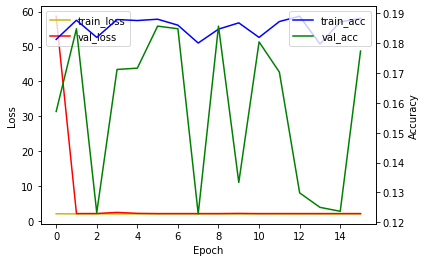

In [61]:
acc_loss_plot(history)